In [6]:
import trimesh
import numpy as np
from scipy import integrate, optimize
import math

In [7]:
trimesh.load("/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/Oblique1T.obj").volume

4.397630983694728

In [3]:
def R(x, s, C):
    return s * np.sqrt(1.2**2 - x**2) * (0.1*x + C)

def A_slice(x, s, u, C):
    d = 2*x + u
    R0 = R(x, s, C)
    if d >= R0:
        return 0.0  # Entire disk is below the plane → remove all
    elif d <= -R0:
        return np.pi * R0**2  # Entire disk is above the plane → keep all
    else:
        return R0**2 * np.arccos(d / R0) - d * np.sqrt(R0**2 - d**2)

def V_total(s, u, C):
    f = lambda x: A_slice(x, s, u, C)
    return integrate.quad(f, -1.2, 1.2)[0]

def find_s(u, C):
    # target volume = 1.4*pi
    target = 1.4*np.pi
    root = optimize.brentq(lambda s: V_total(s, u, C) - target,
                          a=1e-3, b=1e3)
    return root

C = np.sqrt(544283/10)/300
V_total(1, -3, C)
find_s(-1, C)

1.167870516925169

In [5]:
V_total(1, -1, C)

3.2467044950125805

In [4]:
find_s(-1, C)

1.167870516925169

In [7]:
find_s(-2, C)

1.024821538398861

In [8]:
find_s(-1.5, C)

1.0794698191816499

In [5]:
find_s(0, C)

1.4803106027848818

In [11]:
[round(u, 2) for u in np.arange(-2.7, -0.7 + 0.01, 0.2)]


[-2.7, -2.5, -2.3, -2.1, -1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7]

In [9]:
# Parameters (match Desmos)
d = 2.8
f = 24
t = 0.5

# Derived values
v = d / t - 4.9 * t
print(f"Initial velocity v = {v:.2f}")

# Function definition for g(x)
def g(x, d, f, t):
    linear = (d / f - 4.9 * t**2 / f) * x
    quad = 4.9 * (x * t / f)**2
    return linear + quad

# Discrete steps from x = 0 to f
X = np.arange(0, f + 1)
g_X = g(X, d, f, t)

# Compute transformed u values
u_values = (d - g_X) * np.sqrt(5)
-u_values.round(2)

Initial velocity v = 3.15


array([-6.26, -6.11, -5.95, -5.78, -5.6 , -5.41, -5.21, -5.  , -4.78,
       -4.56, -4.32, -4.07, -3.82, -3.55, -3.27, -2.99, -2.7 , -2.39,
       -2.08, -1.76, -1.42, -1.08, -0.73, -0.37, -0.  ])

In [9]:
import torch
import trimesh
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes

# Paths
mesh_path = "/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/Oblique9.obj"

# Load using trimesh (for visualization)
trimesh_mesh = trimesh.load(mesh_path, process=True)
trimesh_mesh.show()  # This will open an interactive viewer

# Load using PyTorch3D
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p3d_mesh = load_objs_as_meshes([mesh_path], device=device)

# p3d_mesh now contains verts and faces
print(f"Loaded PyTorch3D mesh with {p3d_mesh.num_verts_per_mesh()[0]} vertices "
      f"and {p3d_mesh.num_faces_per_mesh()[0]} faces.")


Loaded PyTorch3D mesh with 32332 vertices and 64660 faces.


/Users/jeffreyliang/Documents/Honours/venv/lib/python3.12/site-packages/pytorch3d/io/obj_io.py:547: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [10]:
trimesh_mesh.show()

32332
32332


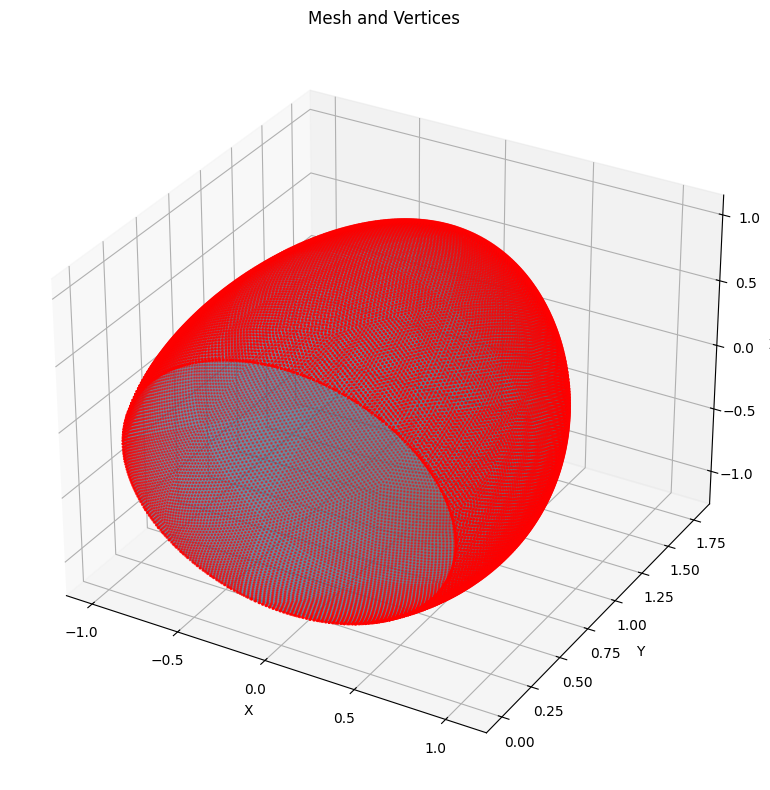

In [14]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np

# Load the mesh
mesh_path = "/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/Oblique9.obj"
mesh = trimesh.load(mesh_path, process=True)
verts = mesh.vertices
print(len(verts))
mesh.subdivide()

# Extract vertices and faces
verts = mesh.vertices
print(len(verts))
faces = mesh.faces

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot mesh as wireframe
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                linewidth=0.2, alpha=0.4, edgecolor='gray')

# Plot vertices as red points
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='red', s=1)

ax.set_title("Mesh and Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


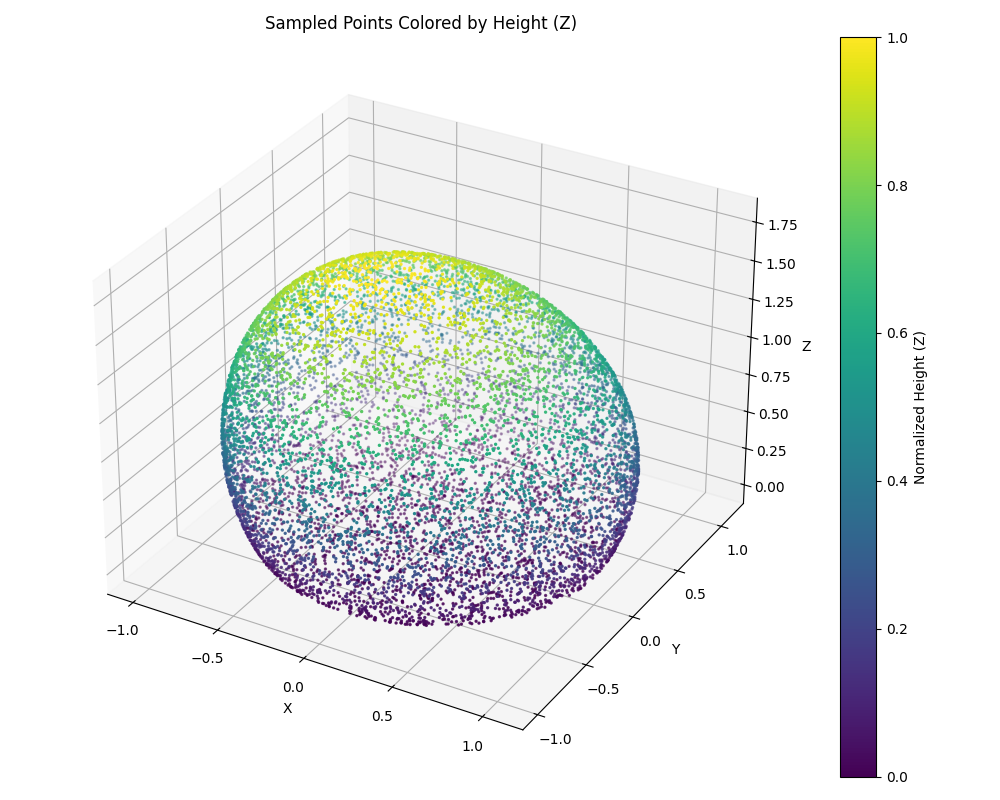

In [21]:
import torch
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load mesh
mesh_path = "/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/Oblique9.obj"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
verts, faces, _ = load_obj(mesh_path)

# Apply axis swap: x, -z, y
verts = torch.stack([verts[:, 0], -verts[:, 2], verts[:, 1]], dim=1)

# Convert faces to packed format
faces_idx = faces.verts_idx

# Create Meshes object
mesh = Meshes(verts=[verts.to(device)], faces=[faces_idx.to(device)])

# Sample surface points
num_samples = 10000
samples = sample_points_from_meshes(mesh, num_samples=num_samples)[0]  # (N, 3)
samples_np = samples.cpu().numpy()

# Color by height (Z-axis)
heights = samples_np[:, 2]
norm_heights = (heights - heights.min()) / (heights.max() - heights.min())

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    samples_np[:, 0],
    samples_np[:, 1],
    samples_np[:, 2],
    c=norm_heights,
    cmap='viridis',
    s=2
)
ax.set_title(f"Sampled Points Colored by Height (Z)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
fig.colorbar(scatter, ax=ax, label="Normalized Height (Z)")
plt.tight_layout()
plt.show()


In [25]:
import time
import torch
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance

# Load and process mesh
mesh_path = "/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/Oblique9.obj"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

verts, faces, _ = load_obj(mesh_path)
verts = torch.stack([verts[:, 0], -verts[:, 2], verts[:, 1]], dim=1)
faces_idx = faces.verts_idx
mesh = Meshes(verts=[verts.to(device)], faces=[faces_idx.to(device)])

# Time sampling + chamfer
num_samples = 10000
start = time.time()

x = sample_points_from_meshes(mesh, num_samples=num_samples)
y = sample_points_from_meshes(mesh, num_samples=num_samples)

dist, _ = chamfer_distance(x, y, point_reduction="mean", batch_reduction=None)

end = time.time()

print(f"Chamfer(x, y) = {dist.item():.6f}")
print(f"Time (sampling + chamfer): {end - start:.4f} seconds")


Chamfer(x, y) = 0.000872
Time (sampling + chamfer): 0.5729 seconds


In [26]:
1300 * 0.5 /60

10.833333333333334

In [7]:
import trimesh
from pathlib import Path
import math
base_dir = Path("/home/jeffrey/honours/src/data/meshes")
tot =0
for i in range(5):
    mesh_path = base_dir / f"Oblique{i}.obj"
    mesh = trimesh.load(mesh_path, process=True)
    volume = mesh.volume
    print(f"Oblique{i}: Volume = {volume:.10f}  Volume = {(1.4 * math.pi - volume):.10f}")
    tot += volume
print(tot/5)

Oblique0: Volume = 4.3976309434  Volume = 0.0005987717
Oblique1: Volume = 4.3976309837  Volume = 0.0005987313
Oblique2: Volume = 4.3976309270  Volume = 0.0005987881
Oblique3: Volume = 4.3976309593  Volume = 0.0005987557
Oblique4: Volume = 4.3976309880  Volume = 0.0005987270
4.39763096025489
